# Week 09 — PyTorch Fundamentals

This notebook gets you practical with PyTorch. You'll:
- Master tensors, broadcasting, and autograd
- Build models using `nn.Module`
- Implement training loops with DataLoader
- Save and load checkpoints

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


In [ ]:

import os, pickle

CACHE_DIR = "cache_week13"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week09


## 1. Tensors and Autograd

Learn tensor operations, broadcasting, and automatic differentiation.

In [3]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3, 4)
z = torch.zeros(2, 3)

print("Tensor x:", x)
print("Tensor y shape:", y.shape)
print("Tensor z:", z)

# Broadcasting
a = torch.tensor([[1.0], [2.0], [3.0]])  # shape: (3, 1)
b = torch.tensor([10.0, 20.0, 30.0])    # shape: (3,)
c = a + b  # Broadcasting: (3, 1) + (3,) -> (3, 3)
print("\nBroadcasting result shape:", c.shape)
print(c)

# Autograd basics
x = torch.tensor(2.0, requires_grad=True)
y = x ** 2 + 3 * x + 1
print(f"\ny = x² + 3x + 1")
print(f"y({x.item()}) = {y.item()}")

# Compute gradient
y.backward()
print(f"dy/dx at x={x.item()}: {x.grad.item()}")
print(f"Analytic dy/dx = 2x + 3 = {2*x.item() + 3}")

Tensor x: tensor([1., 2., 3.])
Tensor y shape: torch.Size([3, 4])
Tensor z: tensor([[0., 0., 0.],
        [0., 0., 0.]])

Broadcasting result shape: torch.Size([3, 3])
tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])

y = x² + 3x + 1
y(2.0) = 11.0
dy/dx at x=2.0: 7.0
Analytic dy/dx = 2x + 3 = 7.0


## 2. Build a Model with nn.Module

Re-implement the from-scratch neural network using PyTorch's `nn.Module`.

In [4]:
# Define a simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create model
model = SimpleMLP(input_size=10, hidden_size=50, output_size=2)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Forward pass
x_sample = torch.randn(5, 10)
output = model(x_sample)
print(f"\nInput shape: {x_sample.shape}")
print(f"Output shape: {output.shape}")

SimpleMLP(
  (fc1): Linear(in_features=10, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

Total parameters: 652
Trainable parameters: 652

Input shape: torch.Size([5, 10])
Output shape: torch.Size([5, 2])


## 3. Training Loop with DataLoader

Implement a complete training loop with mini-batches.

In [5]:
# Generate synthetic dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_np, y_np = make_classification(n_samples=1000, n_features=10, n_informative=8,
                                 n_classes=2, random_state=42)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train_np)
y_train = torch.LongTensor(y_train_np)
X_test = torch.FloatTensor(X_test_np)
y_test = torch.LongTensor(y_test_np)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 800
Test samples: 200
Batches per epoch: 25


[cache] computing 'pytorch_mlp_50epochs'...
Epoch 10/50: Train Loss=0.2901, Acc=0.9038, Test Loss=0.3438, Acc=0.8800
Epoch 20/50: Train Loss=0.1999, Acc=0.9250, Test Loss=0.2692, Acc=0.9100
Epoch 30/50: Train Loss=0.1646, Acc=0.9363, Test Loss=0.2489, Acc=0.9000
Epoch 40/50: Train Loss=0.1437, Acc=0.9437, Test Loss=0.2356, Acc=0.9000
Epoch 50/50: Train Loss=0.1275, Acc=0.9525, Test Loss=0.2373, Acc=0.8950


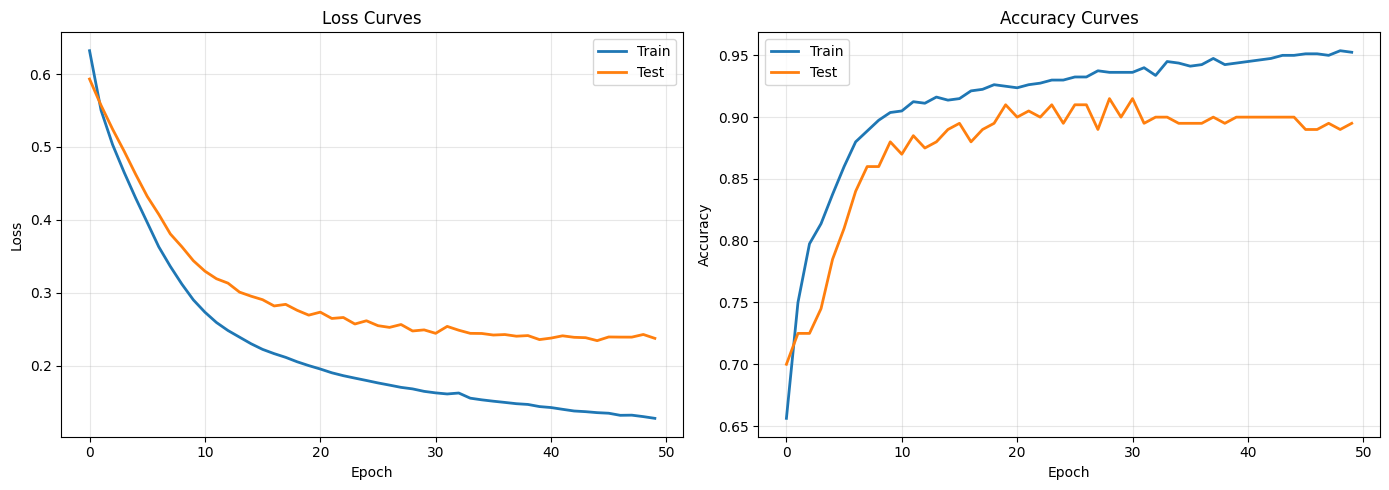

In [6]:

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_x, batch_y in loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    return total_loss / len(loader), correct / total

def _train_mlp():
    m = SimpleMLP(input_size=10, hidden_size=64, output_size=2)
    opt = optim.Adam(m.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    tl, tt, ta, ta_ = [], [], [], []
    for epoch in range(50):
        trl, tra = train_epoch(m, train_loader, crit, opt)
        tel, tea = evaluate(m, test_loader, crit)
        tl.append(trl); tt.append(tel); ta.append(tra); ta_.append(tea)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/50: Train Loss={trl:.4f}, Acc={tra:.4f}, "
                  f"Test Loss={tel:.4f}, Acc={tea:.4f}")
    return m.state_dict(), tl, tt, ta, ta_

state_dict, train_losses, test_losses, train_accs, test_accs = cached(
    "pytorch_mlp_50epochs", _train_mlp)

# Reload weights
model = SimpleMLP(input_size=10, hidden_size=64, output_size=2)
model.load_state_dict(state_dict)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(test_losses,  label='Test',  linewidth=2)
axes[0].set(xlabel='Epoch', ylabel='Loss',     title='Loss Curves');     axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(train_accs,   label='Train', linewidth=2)
axes[1].plot(test_accs,    label='Test',  linewidth=2)
axes[1].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy Curves'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()


## 4. Checkpointing: Save and Load Models

Save model state and resume training.

In [7]:

# Checkpoint: save to cache_week09/pytorch_mlp_checkpoint.pth (auto-reuses if present)
import torch

ckpt_path = os.path.join(CACHE_DIR, "pytorch_mlp_checkpoint.pth")

if os.path.exists(ckpt_path):
    print(f"[checkpoint] Loading from {ckpt_path}")
    checkpoint = torch.load(ckpt_path)
else:
    optimizer_ckpt = optim.Adam(model.parameters(), lr=0.001)
    checkpoint = {
        'epoch': 50,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer_ckpt.state_dict(),
        'train_loss': train_losses[-1],
        'test_loss':  test_losses[-1],
    }
    torch.save(checkpoint, ckpt_path)
    print(f"[checkpoint] Saved to {ckpt_path}")

# Restore model
loaded_model = SimpleMLP(input_size=10, hidden_size=64, output_size=2)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

criterion = nn.CrossEntropyLoss()
_, loaded_acc = evaluate(loaded_model, test_loader, criterion)
print(f"Loaded model test accuracy: {loaded_acc:.4f}")
print(f"Parameters match: {all(torch.equal(p1, p2) for p1, p2 in zip(model.parameters(), loaded_model.parameters()))}")


[checkpoint] Saved to cache_week09\pytorch_mlp_checkpoint.pth
Loaded model test accuracy: 0.8950
Parameters match: True


## 5. Gradient Comparison with Manual Implementation

Compare PyTorch autograd to manual gradients from Week 07.

In [8]:
# Simple function: y = w1*x1 + w2*x2 + b
x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(3.0, requires_grad=True)
w1 = torch.tensor(0.5, requires_grad=True)
w2 = torch.tensor(-0.3, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# Forward
y = w1 * x1 + w2 * x2 + b
print(f"y = {y.item():.4f}")

# Backward (autograd)
y.backward()

print("\nAutograd gradients:")
print(f"  dy/dw1 = {w1.grad.item():.4f}")
print(f"  dy/dw2 = {w2.grad.item():.4f}")
print(f"  dy/db  = {b.grad.item():.4f}")

# Manual gradients (should match)
print("\nManual gradients:")
print(f"  dy/dw1 = x1 = {x1.item():.4f}")
print(f"  dy/dw2 = x2 = {x2.item():.4f}")
print(f"  dy/db  = 1  = 1.0000")

print("\n→ Autograd matches manual computation!")

y = 1.1000

Autograd gradients:
  dy/dw1 = 2.0000
  dy/dw2 = 3.0000
  dy/db  = 1.0000

Manual gradients:
  dy/dw1 = x1 = 2.0000
  dy/dw2 = x2 = 3.0000
  dy/db  = 1  = 1.0000

→ Autograd matches manual computation!


## Exercises for Further Practice

1. **Custom Dataset**: Implement a custom `Dataset` class for image data
2. **Learning Rate Scheduler**: Add `torch.optim.lr_scheduler` and compare schedules
3. **GPU Training**: Move model and data to GPU (if available) and measure speedup
4. **Data Augmentation**: Implement transforms for data augmentation
5. **TensorBoard**: Log metrics to TensorBoard for visualization

## Deliverables Checklist

- [ ] PyTorch model implementation using nn.Module
- [ ] Training loop with DataLoader
- [ ] Checkpoint save/load demonstration
- [ ] Gradient comparison between autograd and manual computation

## Recommended Resources

- Official PyTorch tutorials (60-minute blitz)
- PyTorch documentation on autograd and nn.Module
- Fast.ai course (practical deep learning with PyTorch)

In [9]:

# EXERCISE 1 — Custom Dataset Class
# Goal: implement a class MyTabularDataset(Dataset) that wraps a numpy array.
# It should implement __len__ and __getitem__ and return (FloatTensor, LongTensor).
# Feed it to DataLoader and confirm training produces same results as TensorDataset.
# Expected insight: custom datasets are the entry point for real-world data pipelines.


In [10]:

# EXERCISE 2 — Learning Rate Scheduler
# Goal: add CosineAnnealingLR (T_max=50) to the training loop.
# Plot the LR schedule alongside the loss curve. Compare final test accuracy
# to the constant-LR baseline above.
# Use cached("pytorch_mlp_cosine_lr_50epochs", ...) for this run.
# Expected insight: annealing often improves final accuracy at minimal cost.


In [11]:

# EXERCISE 4 — GPU Device Portability
# Goal: rewrite the training loop to be device-agnostic using
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model, data tensors, and DataLoaders to the chosen device.
# Wrap in cached("pytorch_mlp_gpu_50epochs", ...).
# Expected insight: a one-line device switch is all it takes to use a GPU.
